In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from datetime import datetime

from graph_gen import (
  lognorm_amount,
  populate,
  simulate,
  make_undirectional
)

from scores_gen import (
  generate_scores
)

%matplotlib inline
%config InlineBackend.figure_format='retina'


## Граф

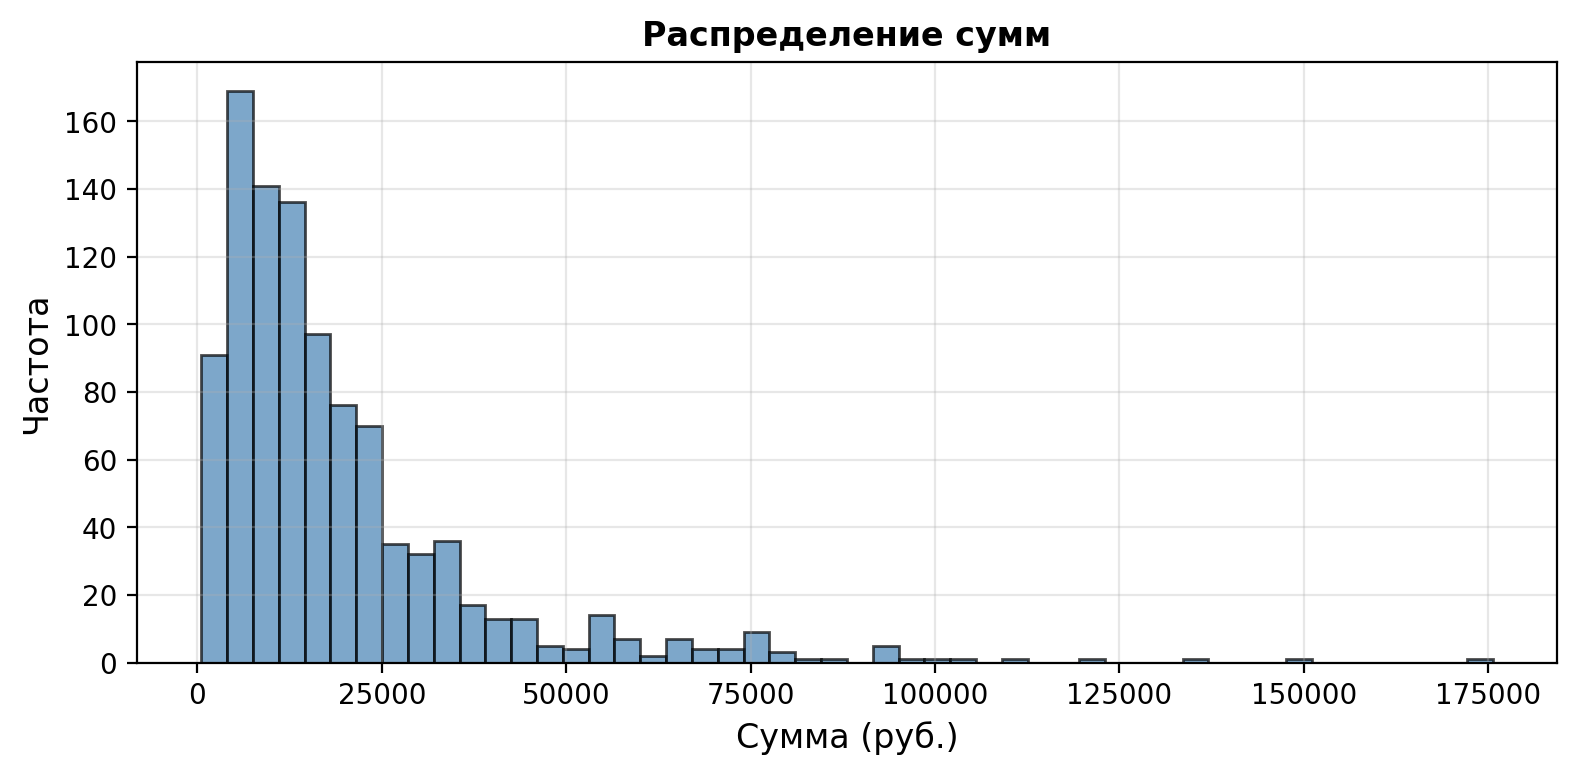

In [73]:
sums = []
for _ in range(1000):
  sums.append(lognorm_amount(
    min_rub=100.0, 
        mean_rub=20000.0, 
        sigma=0.9
  ))
  
plt.figure(figsize=(8, 4))
plt.hist(sums, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
plt.xlabel('Сумма (руб.)', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.title('Распределение сумм', fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [74]:
start_date = datetime(2025, 1, 1)
end_date = datetime(2025, 1, 31)

p, h = populate(
  population=100,
  vender_frac=0.05
)

trx = simulate(
  people=p,
  households=h,
  start_date=start_date,
  end_date=end_date,
  noise_rate=0.005
)

df = make_undirectional(trx)

df.head()

,src,dst,timestamp,amount
0,92,5,2025-01-01 09:54:52,325225.351764
1,47,50,2025-01-01 11:29:32,71942.194763
2,61,25,2025-01-01 13:48:25,18596.112878
3,28,42,2025-01-01 14:21:19,309259.023364
4,97,25,2025-01-01 14:55:03,16505.138342


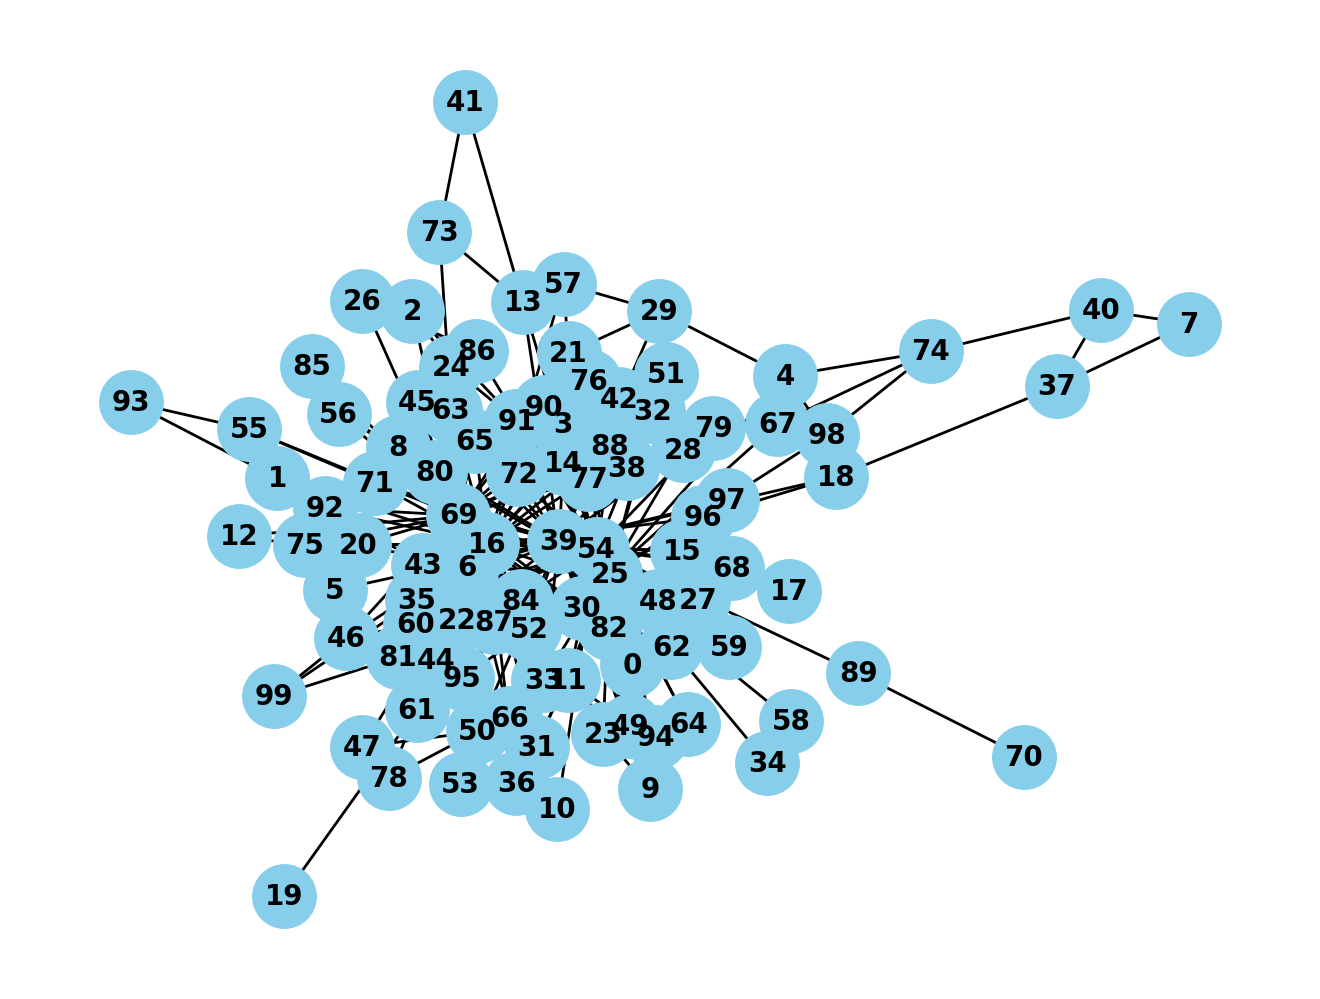

In [75]:
g = nx.from_pandas_edgelist(df=df, source='src', target='dst', edge_attr='amount')
pos = nx.spring_layout(g)
nx.draw(
  g, 
  pos, 
  with_labels=True, 
  node_size=500, 
  node_color='skyblue', 
  font_size=10, 
  font_weight='bold'
)


In [163]:
set(df.query('src == 58 or dst == 58')[['src','dst']].values.flat) - set([58])

{np.int64(47), np.int64(69), np.int64(72), np.int64(89)}

## Граф из файла

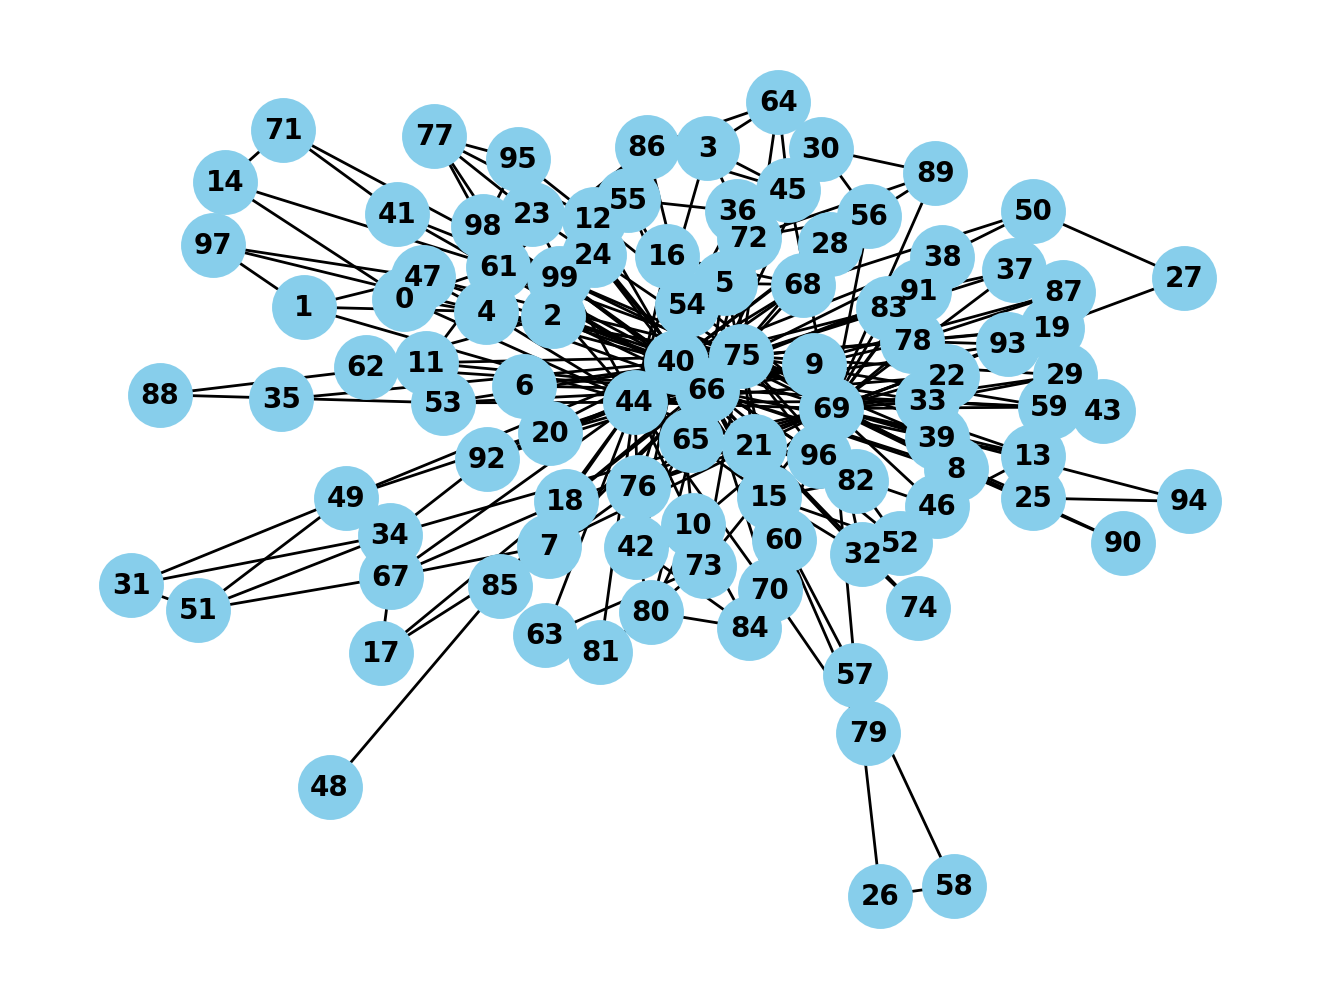

In [76]:
df_graph = pd.read_csv('data/transactions.csv')
g = nx.from_pandas_edgelist(df=df_graph, source='src', target='dst', edge_attr='amount')
pos = nx.spring_layout(g)
nx.draw(
  g, 
  pos, 
  with_labels=True, 
  node_size=500, 
  node_color='skyblue', 
  font_size=10, 
  font_weight='bold'
)


## Скоринги

In [77]:
from utils import load_scores, load_pk, load_sk

pk = load_pk('keys/pk.json')
sk = load_sk('keys/sk.json', pk)
scores = load_scores(load_pk('keys/pk.json'), 'data/scores.csv')
df_scores = pd.read_csv('data/scores.csv')

In [80]:
pid = 56

friends = list(set(df_graph.query(f'src == {pid} or dst == {pid}')[['src','dst']].values.flat) - set([pid]))

print(f'friends = {[int(i) for i in friends]}')

if len(friends) > 0:
  env_score = scores[friends[0]]
  for friend in friends[1:]:
    env_score += scores[friend]

  env_score /= 7.0
  

  plain_sum = df_scores.query(f'pid == @friends')['score_plain'].sum()
  print(f'plain = {plain_sum}')
  print(f'decrypted = {sk.decrypt(env_score)}')


friends = [69, 40, 72, 89, 30]
plain = 12
decrypted = 1.7142857142857142


## Эксперименты

In [81]:
from phe import paillier

from bank import Bank
from payment_service import PaymentService  

bank = Bank(
  pk_path='keys/pk.json',
  sk_path='keys/sk.json',
  scores_path='data/scores.csv'
)

payment_service = PaymentService(
  pk_path='keys/pk.json',
  graph_path='data/transactions.csv',
  scores_path='data/scores.csv'
)

In [83]:
bank.decrypt(
  payment_service.simple_query(pid)
)

12

## PIR

### Гомоморфное Шифрование

In [92]:


pk, sk = paillier.generate_paillier_keypair(n_length=2048)
pkx, skx = paillier.generate_paillier_keypair(n_length=4112)

enc_a = pk.encrypt(42)

enc_b = pkx.encrypt(1)

enc_a.ciphertext()*enc_b














In [93]:
xx = enc_a.ciphertext()*enc_b

sk.decrypt(paillier.EncryptedNumber(public_key=pk, ciphertext=skx.decrypt(xx)))

42

In [91]:
import math
math.log2(pk.n//3)*2


4090.955467943635

In [94]:
pir_query = bank.make_pir_query_ahe(pid)

func "make_pir_query_ahe" took 1 minute and 16.7801 seconds to execute.


In [95]:
result = payment_service.pir_ahe_query(pir_query)

func "pir_ahe_query" took 1 minute and 27.0822 seconds to execute.


In [96]:
bank.decrypt_ahe(result)

12

## Маскирование

In [98]:
import sys
import random

mask = random.randint(-sys.maxsize, sys.maxsize)

enc_a = pk.encrypt(42)

masked_enc_a = enc_a + mask


In [ ]:
sk.decrypt(masked_enc_a)

-5622377171954486089

In [100]:
print(mask)

-5622377171954486089


In [102]:
pir_query = bank.make_pir_query(pid)

func "make_pir_query" took 10.0930 seconds to execute.


In [103]:
masked_scores = payment_service.get_masked_env_scores()

In [104]:
enc_mask = payment_service.pir_query(pir_query)

func "pir_query" took 0.4736 seconds to execute.


In [105]:
bank.decrypt_pir(masked_scores[pid], enc_mask)

12

In [7]:
from phe import paillier

pk, sk = paillier.generate_paillier_keypair(n_length=16)

pk.n/3

13972.333333333334

In [ ]:
import csv
import random 
from homework import config
from collections import namedtuple

triple = namedtuple('triple', ['a', 'b', 'c'])

p1 = []
p2 = []

for i in range(10):
  a1 = random.randint(0, config.MPC_MODULO)
  a2 = random.randint(0, config.MPC_MODULO)

  b1 = random.randint(0, config.MPC_MODULO)
  b2 = random.randint(0, config.MPC_MODULO)

  c = ((a1+a2) * (b1+b2)) % config.MPC_MODULO
  c1 = random.randint(0, config.MPC_MODULO)
  c2 = (c-c1) % config.MPC_MODULO
  p1.append(triple(a1, b1, c1))
  p2.append(triple(a2, b2, c2))


with open('homework/p1.csv', 'w') as f:
  writer = csv.writer(f)
  writer.writerow(['a', 'b', 'c'])
  for row in p1:
    writer.writerow(row)


with open('homework/p2.csv', 'w') as f:
  writer = csv.writer(f)
  writer.writerow(['a', 'b', 'c'])
  for row in p1:
    writer.writerow(row)




for i in range(10):
  x1 = random.randint(0, config.MPC_MODULO)
  x2 = (x1-random.randint(0, config.MPC_MODULO)) % config.MPC_MODULO

  y1 = random.randint(0, config.MPC_MODULO)
  y2 = (x1-random.randint(0, config.MPC_MODULO)) % config.MPC_MODULO

  r = ((x1+x2) * (y1+y2)) % config.MPC_MODULO

  d = ((x1-p1[i].a) + (x2-p2[i].a)) % config.MPC_MODULO
  e = ((y1-p1[i].b) + (y2-p2[i].b)) % config.MPC_MODULO

  z1 = p1[i].c + d*p1[i].b + e*p1[i].a + d*e
  z2 = p2[i].c + d*p2[i].b + e*p2[i].a
  z = (z1+z2) % config.MPC_MODULO

  if r != z:
    print('Error')
